In [1]:
import numpy as np
import tensorflow as tf
print(tf.__version__)
from collections import deque

replay_buffer = deque(maxlen=2000)

input_shape = [4]   # env.observation_space.shape
n_outputs = 5       # env.action_space.n

initializer = tf.keras.initializers.RandomUniform(minval=-0.01, maxval=0.01)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu", kernel_initializer=initializer,
                            kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(32, activation="elu", kernel_initializer=initializer,
                            kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(n_outputs)
])

2.16.1


In [2]:
def epsilon_greedy_policy(model, state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(2)
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0]
        return np.argmax(Q_values)

def play_one_step(env, model, obs, epsilon, replay_buffer):
    action = epsilon_greedy_policy(model, obs, epsilon)
    actions = {"prisoner": action}
    next_obs, reward, term, trunc, info = env.step(actions)
    next_obs = next_obs["prisoner"] / 10
    reward = reward["prisoner"]
    term = term["prisoner"]
    trunc = trunc["prisoner"]

    replay_buffer.append((obs, action, reward, next_obs, term, trunc))
    
def sample_experiences(replay_buffer, batch_size):
    # print(f"{replay_buffer = }")
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices] # samptling
    n_fields = len(batch[0])
    sample = []
    # "transpose":
    for field_index in range(n_fields): # obs, actions, rewards, next_obs, dones, truncateds
        field_data = []
        for experience in batch:
            field_data.append(experience[field_index])
        sample.append(np.array(field_data))
    return sample  # [obs, actions, rewards, next_obs, dones, truncateds]

def training_step(model, buffer, optimizer, loss_fn, batch_size, discount):
    experiences = sample_experiences(buffer, batch_size)
    obs, actions, rewards, next_obs, terms, truncs = experiences
    next_Q_values = model.predict(next_obs, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)

    runs = 1.0 - (terms | truncs)
    target_Q_values = rewards + runs * discount * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(obs)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        
        # print(f"{target_Q_values = }, {Q_values = }")

        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
        print(f"loss: {float(loss)}")
    grads = tape.gradient(loss, model.trainable_variables)
    if float(loss) < 5:
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
    else:
        print(f"reject, loss = {float(loss)}")
    

In [3]:
import escape

max_cycles = 52
env = escape.env(render_mode=None, max_cycles=max_cycles)
# env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)

batch_size = 16
discount_factor = 0.95
lr = 0.03
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr)
loss_fn = tf.keras.losses.mse

pygame 2.3.0 (SDL 2.24.2, Python 3.11.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
best_score = 0

for episode in range(600):
    obs, info = env.reset()
    obs = obs["prisoner"] / 10
    rewards = 0
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        play_one_step(env, model, obs, epsilon, replay_buffer)
        old_obs, act, reward, obs, term, trunc = replay_buffer[-1]
        rewards += reward
        if term or trunc:
            break

    print(f"\rEpisode: {episode+1}, Steps: {step+1}, eps: {epsilon:.3f} {rewards = } ", end="")

    if episode > 50:
        training_step(model, replay_buffer, optimizer,
                    loss_fn, batch_size, discount_factor)

    # rewards.append(step)
    # if step >= best_score:
    #     best_weights = model.get_weights()
    #     best_score = step

# model.set_weights(best_weights)

Episode: 2, Steps: 54, eps: 0.998 rewards = -1.0149612426757812 

c:\Users\ordevoir\Documents\GitHub\Systems_Modeling\PettingZoo\Prisoner-Guard-Prompter\escape.py:175: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. render_mode="rgb_array" or render_mode="rgb_array"
  warn("You are calling render method without specifying any render mode. "


Episode: 52, Steps: 54, eps: 0.898 rewards = -10.448135375976562 loss: 0.025260724127292633
Episode: 53, Steps: 54, eps: 0.896 rewards = -5.883386850357056 loss: 0.056483522057533264
Episode: 54, Steps: 54, eps: 0.894 rewards = -10.723678588867188 loss: 0.14862164855003357
Episode: 55, Steps: 54, eps: 0.892 rewards = -7.163469314575195 loss: 0.1795647144317627
Episode: 56, Steps: 54, eps: 0.890 rewards = 0.4615607261657715 loss: 0.051299817860126495
Episode: 57, Steps: 54, eps: 0.888 rewards = -3.1912899017333984 loss: 0.03981493413448334
Episode: 58, Steps: 54, eps: 0.886 rewards = 4.725107192993164 loss: 0.02420591376721859
Episode: 59, Steps: 54, eps: 0.884 rewards = -5.417366981506348 loss: 0.18017449975013733
Episode: 60, Steps: 54, eps: 0.882 rewards = -10.203292846679688 loss: 0.1857505440711975
Episode: 61, Steps: 54, eps: 0.880 rewards = 5.829423904418945 loss: 0.27243199944496155
Episode: 62, Steps: 54, eps: 0.878 rewards = -8.614362716674805 loss: 0.19541776180267334
Episode

KeyboardInterrupt: 

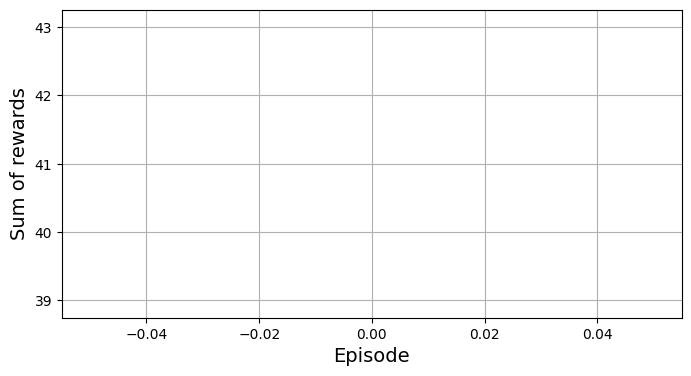

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

In [6]:
# @tf.function
def one_step(env, obs, model):
    prisoner_inputs = tf.convert_to_tensor([obs["prisoner"]])
    output = model.predict(prisoner_inputs, verbose=0)
    predicted_action = int(tf.argmax(output, axis=1))

    actions = {"prisoner": predicted_action}
    print(f"\r{actions = } ", end="")
    obs, rewards, term, trunc, infos = env.step(actions)
    return obs, rewards, term, trunc

def play(env, model, loss_fn):
    obs, info = env.reset()
    # obs, info = env.reset(seed=24)
    rewards_list, grads_list = [], []

    while env.agents:
        obs, rew, term, trunc = one_step(env, obs, model)
        rewards_list.append(rew["prisoner"])
        print(f"{rew = }", end="")
    return rewards_list


In [8]:
environment = escape.env(render_mode="human", max_cycles=1500)
r = play(environment, model, loss_fn)

actions = {'prisoner': 0} rew = {'prisoner': -0.00038337708}

KeyboardInterrupt: 

: 